In [ ]:
import numpy as np
import json
import re
import os
import string

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses

In [ ]:
# Check if GPU is detected
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Optionally, log devices being used
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
# To run on CPU, in case of unavailable GPU or the issue related to CUDA/cuDNN setup.
# try creating a new virtual environment and install the CPU-only version of TensorFlow:

# pip install tensorflow-cpu

## 0. Parameters

In [3]:
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 25

## 1. Load the data

### For Local Downloading

In [ ]:
import os
import shutil

# Create the .kaggle folder in your user directory if it doesn't exist
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Move the kaggle.json file from your working directory to ~/.kaggle
shutil.copy("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))

# Set permissions if needed (safe on Unix-like systems; ignored on Windows)
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

In [ ]:
# !pip install kaggle

In [ ]:
!kaggle datasets download -d hugodarwood/epirecipes

In [ ]:
import zipfile

with zipfile.ZipFile("epirecipes.zip", 'r') as zip_ref:
    zip_ref.extractall("epirecipes")

### For Colab Downloading

In [ ]:
# 1. Go to Kaggle → Account Settings
# - Click "Create New API Token" → this downloads kaggle.json.

# 2. Upload it in Colab:

from google.colab import files
uploaded = files.upload()  # Upload the kaggle.json file here

In [5]:
# Setup the API credentials:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d hugodarwood/epirecipes
!unzip -q epirecipes.zip -d epirecipes

Dataset URL: https://www.kaggle.com/datasets/hugodarwood/epirecipes
License(s): unknown
  0% 0.00/11.3M [00:00<?, ?B/s]
100% 11.3M/11.3M [00:00<00:00, 1.17GB/s]


### Load the full dataset

In [7]:
# Load the full dataset
with open("epirecipes/full_format_recipes.json") as json_data:
    recipe_data = json.load(json_data)

In [8]:
# Filter the dataset
filtered_data = [
    "Recipe for " + x["title"] + " | " + " ".join(x["directions"])
    for x in recipe_data
    if "title" in x
    and x["title"] is not None
    and "directions" in x
    and x["directions"] is not None
]

In [9]:
# Count the recipes
n_recipes = len(filtered_data)
print(f"{n_recipes} recipes loaded")

20111 recipes loaded


In [10]:
example = filtered_data[9]
print(example)

Recipe for Ham Persillade with Mustard Potato Salad and Mashed Peas  | Chop enough parsley leaves to measure 1 tablespoon; reserve. Chop remaining leaves and stems and simmer with broth and garlic in a small saucepan, covered, 5 minutes. Meanwhile, sprinkle gelatin over water in a medium bowl and let soften 1 minute. Strain broth through a fine-mesh sieve into bowl with gelatin and stir to dissolve. Season with salt and pepper. Set bowl in an ice bath and cool to room temperature, stirring. Toss ham with reserved parsley and divide among jars. Pour gelatin on top and chill until set, at least 1 hour. Whisk together mayonnaise, mustard, vinegar, 1/4 teaspoon salt, and 1/4 teaspoon pepper in a large bowl. Stir in celery, cornichons, and potatoes. Pulse peas with marjoram, oil, 1/2 teaspoon pepper, and 1/4 teaspoon salt in a food processor to a coarse mash. Layer peas, then potato salad, over ham.


## 2. Tokenise the data

In [11]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in filtered_data]

In [12]:
# Display an example of a recipe
example_data = text_data[9]
example_data

'Recipe for Ham Persillade with Mustard Potato Salad and Mashed Peas | Chop enough parsley leaves to measure 1 tablespoon ; reserve . Chop remaining leaves and stems and simmer with broth and garlic in a small saucepan , covered , 5 minutes . Meanwhile , sprinkle gelatin over water in a medium bowl and let soften 1 minute . Strain broth through a fine - mesh sieve into bowl with gelatin and stir to dissolve . Season with salt and pepper . Set bowl in an ice bath and cool to room temperature , stirring . Toss ham with reserved parsley and divide among jars . Pour gelatin on top and chill until set , at least 1 hour . Whisk together mayonnaise , mustard , vinegar , 1 / 4 teaspoon salt , and 1 / 4 teaspoon pepper in a large bowl . Stir in celery , cornichons , and potatoes . Pulse peas with marjoram , oil , 1 / 2 teaspoon pepper , and 1 / 4 teaspoon salt in a food processor to a coarse mash . Layer peas , then potato salad , over ham . '

In [13]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [14]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [15]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [16]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: .
3: ,
4: and
5: to
6: in
7: the
8: with
9: a


In [17]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[  26   16  557    1    8  298  335  189    4 1054  494   27  332  228
  235  262    5  594   11  133   22  311    2  332   45  262    4  671
    4   70    8  171    4   81    6    9   65   80    3  121    3   59
   12    2  299    3   88  650   20   39    6    9   29   21    4   67
  529   11  164    2  320  171  102    9  374   13  643  306   25   21
    8  650    4   42    5  931    2   63    8   24    4   33    2  114
   21    6  178  181 1245    4   60    5  140  112    3   48    2  117
  557    8  285  235    4  200  292  980    2  107  650   28   72    4
  108   10  114    3   57  204   11  172    2   73  110  482    3  298
    3  190    3   11   23   32  142   24    3    4   11   23   32  142
   33    6    9   30   21    2   42    6  353    3 3224    3    4  150
    2  437  494    8 1281    3   37    3   11   23   15  142   33    3
    4   11   23   32  142   24    6    9  291  188    5    9  412  572
    2  230  494    3   46  335  189    3   20  557    2    0    0    0
    0 

## 3. Create the Training Set

In [18]:
# Create the training set of recipes and the same text shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

## 4. Build the LSTM

In [19]:
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 10000)    │     1,290,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,407,248 (9.18 MB)

 Trainable params: 2,407,248 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
if LOAD_MODEL:
    # model.load_weights('./models/model')
    lstm = models.load_model("./models/lstm", compile=False)

## 5. Train the LSTM

In [21]:
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

In [22]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }  # <1>

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]  # <3>
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:  # <4>
            x = np.array([start_tokens])
            y = self.model.predict(x, verbose=0)  # <5>
            sample_token, probs = self.sample_from(y[0][-1], temperature)  # <6>
            info.append({"prompt": start_prompt, "word_probs": probs})
            start_tokens.append(sample_token)  # <7>
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("recipe for", max_tokens=100, temperature=1.0)

In [23]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [ ]:
history = lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, tensorboard_callback, text_generator],
)

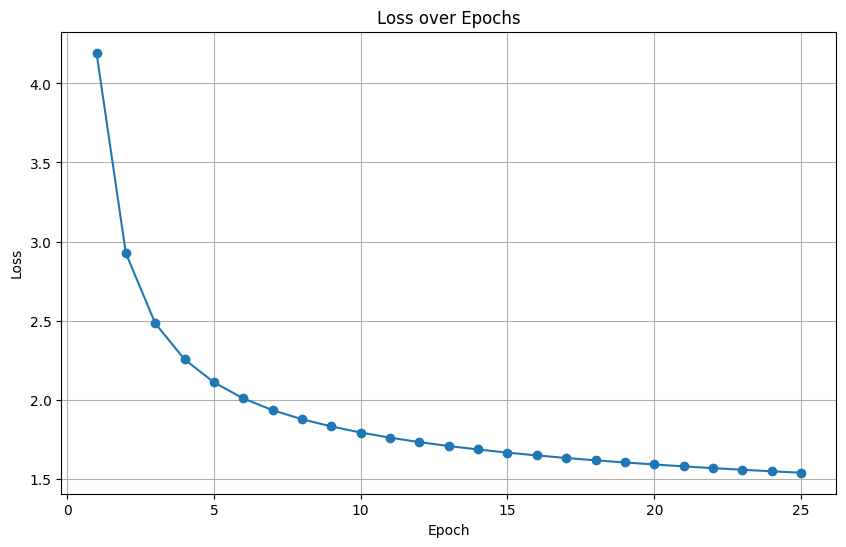

In [25]:
import matplotlib.pyplot as plt

# Extract the loss values
loss = history.history['loss']

# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss)+1), loss, marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [26]:
# Create the 'models' directory if it doesn't exist
os.makedirs("./models", exist_ok=True)

# Save the final model
lstm.save("./models/lstm.keras")

## 6. Generate text using the LSTM

In [27]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        print(f"\nPROMPT: {i['prompt']}")
        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [28]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", max_tokens=10, temperature=1.0
)


generated text:
recipe for roasted vegetables | chop 1 / 8 cup



In [29]:
print_probs(info, vocab)


PROMPT: recipe for roasted vegetables | chop 1 /
4:   	48.459999084472656%
2:   	33.869998931884766%
3:   	14.100000381469727%
8:   	2.680000066757202%
6:   	0.10000000149011612%
--------


PROMPT: recipe for roasted vegetables | chop 1 / 8
cup:   	44.959999084472656%
inch:   	26.8799991607666%
teaspoon:   	5.570000171661377%
":   	4.289999961853027%
of:   	4.230000019073486%
--------



In [30]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", max_tokens=10, temperature=0.2
)


generated text:
recipe for roasted vegetables | chop 1 / 4 cup



In [31]:
print_probs(info, vocab)


PROMPT: recipe for roasted vegetables | chop 1 /
4:   	85.55000305175781%
2:   	14.279999732971191%
3:   	0.18000000715255737%
8:   	0.0%
6:   	0.0%
--------


PROMPT: recipe for roasted vegetables | chop 1 / 4
cup:   	100.0%
inch:   	0.0%
teaspoon:   	0.0%
tsp:   	0.0%
of:   	0.0%
--------



In [32]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_tokens=7, temperature=1.0
)
print_probs(info, vocab)


generated text:
recipe for chocolate ice cream | whisk


PROMPT: recipe for chocolate ice cream |
whisk:   	13.5%
bring:   	13.289999961853027%
combine:   	9.390000343322754%
in:   	8.680000305175781%
beat:   	6.340000152587891%
--------



In [33]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_tokens=7, temperature=0.2
)
print_probs(info, vocab)


generated text:
recipe for chocolate ice cream | bring


PROMPT: recipe for chocolate ice cream |
whisk:   	44.70000076293945%
bring:   	41.31999969482422%
combine:   	7.28000020980835%
in:   	4.889999866485596%
beat:   	1.0199999809265137%
--------



Let's break down exactly **what’s going on here** and how our **trained LSTM model generates text** and how the **temperature parameter** affects word prediction probabilities.

---

## 📌 What Are We Doing?

We're using our trained **LSTM model** to **generate a recipe** step-by-step by predicting **the next word**, given a starting **prompt** (e.g., `"recipe for roasted vegetables | chop 1 /"`).

Then we're printing:

* The **generated words**, and
* The **top 5 most likely next words** (with their probabilities)

---

## 🔥 What Is Temperature?

**Temperature** controls how **creative or confident** the model is when choosing the next word:

| Temperature | Meaning                                                        |
| ----------- | -------------------------------------------------------------- |
| **1.0**     | More random / creative (explores lower-probability words more) |
| **0.2**     | More confident / safe (sticks to highest-probability choices)  |

---

## 🧪 Example Breakdown

### **Example 1: High Temperature (1.0)**

**Prompt:** `"recipe for roasted vegetables | chop 1 /"`

🧠 **Generated Text:** `"recipe for roasted vegetables | chop 1 / 8 cup"`

The model chooses `"8"` as the next word. The **top 5 possible next words were**:

| Token | Probability |
| ----- | ----------- |
| 4     | 48.46%      |
| 2     | 33.87%      |
| 3     | 14.10%      |
| 8     | 2.68%       |
| 6     | 0.10%       |

➡️ `"8"` had **only 2.68%** chance, but was still picked due to the randomness allowed by temperature = 1.0.

Then it predicted `"cup"` next:

| Word     | Probability |
| -------- | ----------- |
| cup      | 44.96%      |
| inch     | 26.88%      |
| teaspoon | 5.57%       |
| "        | 4.29%       |
| of       | 4.23%       |

---

### **Example 2: Low Temperature (0.2)**

**Prompt:** `"recipe for roasted vegetables | chop 1 /"`

🧠 **Generated Text:** `"recipe for roasted vegetables | chop 1 / 4 cup"`

Now look at the predictions:

| Token | Probability |
| ----- | ----------- |
| 4     | 85.55%      |
| 2     | 14.28%      |
| 3     | 0.18%       |
| 8     | 0.0%        |
| 6     | 0.0%        |

➡️ The model **chose the top word ("4") with 85.55% confidence**, and next picked `"cup"` with **100% certainty**.

This is **very deterministic behavior**, which is typical for low temperatures.

---

### **Example 3: Chocolate Ice Cream (Temperature = 1.0)**

**Prompt:** `"recipe for chocolate ice cream |"`

🧠 **Generated Text:** `"recipe for chocolate ice cream | whisk"`

**Top 5 word options:**

| Word    | Probability |
| ------- | ----------- |
| whisk   | 13.5%       |
| bring   | 13.29%      |
| combine | 9.39%       |
| in      | 8.68%       |
| beat    | 6.34%       |

✅ So `"whisk"` was the top choice, but only barely. Other verbs like `"bring"` or `"combine"` were close.

---

### **Example 4: Chocolate Ice Cream (Temperature = 0.2)**

🧠 **Generated Text:** `"recipe for chocolate ice cream | bring"`

**Top 5 options:**

| Word    | Probability |
| ------- | ----------- |
| whisk   | 44.70%      |
| bring   | 41.32%      |
| combine | 7.28%       |
| in      | 4.89%       |
| beat    | 1.02%       |

➡️ It chose `"bring"`, the **second most likely**, but still with a **very high probability**. Lower-temp models still allow some randomness, just less.

---

## 🧠 What This Tells Us

### High Temperature (1.0)

* More **creative** and **diverse**
* Can pick less obvious words
* Sometimes fun, but risky or strange (e.g., "8 cup")

### Low Temperature (0.2)

* More **accurate** and **predictable**
* Sticks to top choices (e.g., "4 cup")
* Safer and more realistic

---

## 🔍 Summary

| Feature          | High Temp (1.0)      | Low Temp (0.2)             |
| ---------------- | -------------------- | -------------------------- |
| Creativity       | High                 | Low                        |
| Risk of mistakes | Higher               | Lower                      |
| Repetition       | Lower (more variety) | Higher (repeats top words) |
| Use case         | Exploration, fun     | Reliable predictions       |

---